In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_shape, interm_dim=150,latent_dim=16,variational=False):
        super(Encoder, self).__init__()
        self.variational=variational
        n_freqs, n_times = input_shape
        # Capas convolucionales
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,5),stride=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3,3),stride=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))##Comentar
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3,3),stride=2)
        

        # Determinación de shape luego de convolución
        self.conv_c_out,self.conv_h_out,self.conv_w_out=self._get_conv_output(input_shape)
        self.conv_output_size = self.conv_c_out*self.conv_h_out*self.conv_w_out

        # Capas fully connected para espacio latente
        self.fc_1=nn.Linear(self.conv_output_size,interm_dim)
        self.fc_mu = nn.Linear(interm_dim, latent_dim) #De representación intermedia a latente
        if self.variational:
            self.fc_logvar = nn.Linear(self.interm_dim, latent_dim)

    def _get_conv_output(self, input_shape):
        """Función auxiliar en cálculo de tamaño tras convoluciones
        Retorna (C_out,H_out,W_out): numero de canales, altura y ancho de salida."""
        with torch.no_grad():
            x = torch.zeros(1, 1, *input_shape)  # Create a dummy input with batch size 1
            x = self.conv1(x)
            #x = self.maxpool1(x)
            x = self.conv2(x)
            #x = self.maxpool2(x)
            x = self.conv3(x)
            print("Numel",x.numel(),  "vs shape1xshape2xshape3: ",x.shape[1]*x.shape[2]*x.shape[3],"shape", x.shape)
            return x.shape[1],x.shape[2],x.shape[3]
            
    def forward(self, x):
        print(f"Input dimensions: {x.shape}")
        x = F.relu(self.conv1(x))
        # x = self.maxpool1(x)
        print(f"Encoder capa 1: {x.shape}")
        x = F.relu(self.conv2(x))
        #x = self.maxpool2(x)
        print(f"Encoder capa 2: {x.shape}")
        x = F.relu(self.conv3(x))
        #x = self.maxpool2(x)
        print(f"Encoder capa 3: {x.shape}")
        # Flatten the output
        x = torch.flatten(x, start_dim=1)
        print("Encoder Forward: Flatten alcanzado. x.hape: ",x.shape, "Predicted output size: ", self.conv_output_size)
        x =F.relu(self.fc_1(x))
        # Obtener parámetros mu, logvarianza
        mu = self.fc_mu(x)
        print("Mu alcanzado",mu.shape)
        if self.variational:
            logvar = self.fc_logvar(x)
            return mu,logvar
        print("Mu igual?",mu.shape)
        return mu

class Decoder(nn.Module):
    def __init__(self, input_shape, encoder_conv_output_shape,interm_dim=150,latent_dim=16):
        super(Decoder, self).__init__()
        self.n_freqs, self.n_times = input_shape
        # Shape luego de convoluciones en el encoder para hacer reshaping
        self.conv_output_shape = encoder_conv_output_shape
        print(self.conv_output_shape)
        encoder_conv_output_size=self.conv_output_shape[0]*self.conv_output_shape[1]*self.conv_output_shape[2]
        # Fully connected layer for reconstructing feature map shape
        self.fc=nn.Linear(latent_dim,interm_dim)
        self.fc_1 = nn.Linear(interm_dim, encoder_conv_output_size)#C*H*W
        #En el forward, se hace el view y se obtiene dimensión (C,H,W) de representación intermedia
        
        # Deconvolution layers
        self.deconv1 = nn.ConvTranspose2d(16, 8, kernel_size=(3, 3),stride=2,output_padding=1)
        self.upsample1 = nn.Upsample(scale_factor=(2, 2))
        self.deconv2 = nn.ConvTranspose2d(8, 8, kernel_size=(3, 3),stride=2,output_padding=(0,1))
        self.upsample2 = nn.Upsample(scale_factor=(2, 2))
        self.deconv3 = nn.ConvTranspose2d(8, 1, kernel_size=(3, 5),stride=2,output_padding=1)

    def forward(self, x):
        # Decode fully connected to a feature map
        #x = self.fc(z)
        x = F.relu(self.fc(x))
        print(f"Decoder capa lineal 1: {x.shape}")
        x = F.relu(self.fc_1(x))
        print(f"Decoder capa lineal 2: {x.shape}")
        # El 1 se refiere a a la dimensión 
        x = x.unflatten(1, self.conv_output_shape) # "desarma" la dimensión 1 en (C,H,W)
        print(f"Decoder unflattened: {x.shape}")
        #x = x.view(-1, self.conv_output_shape[0],self.conv_output_shape[1],self.conv_output_shape[2])# C(canales), H, W
        #print(f"Decoder x.view: {x.shape}")
        # Apply deconvolutions
        x = F.relu(self.deconv1(x))
        #x = self.upsample1(x)
        print(f"Decoder capa 1: {x.shape}")
        
        x = F.relu(self.deconv2(x))
        #x = self.upsample1(x)
        print(f"Decoder capa 2: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #x = self.upsample2(x)
        print(f"Decoder capa 2: {x.shape}")
        
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape, interm_dim=150,latent_dim=16,variational=False):
        super(VariationalAutoencoder, self).__init__()
        self.variational=variational
        self.encoder = Encoder(input_shape, interm_dim=interm_dim,latent_dim=latent_dim,variational=variational)
        encoder_conv_c_h_w_out=(self.encoder.conv_c_out,self.encoder.conv_h_out,self.encoder.conv_w_out)
        print("Instanciado encoder")
        self.decoder = Decoder(input_shape,encoder_conv_c_h_w_out, interm_dim=interm_dim,latent_dim=latent_dim)
        print("Instanciado decoder")
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std
    
    def forward(self, x):
        if self.variational:# Encode
            mu, logvar = self.encoder(x)
            # Reparameterize
            z = self.reparameterize(mu, logvar)
            # Decode
            reconstructed = self.decoder(z)
            return reconstructed, mu, logvar
        else: 
            z=self.encoder(x)
            reconstructer=self.decoder(z)
            return reconstructed
# Define loss function
def loss_funct(reconstructed, original, mu=None, logvar=None, kld_weight=0.1,variational=False):
    """
    Compute VAE loss with weighted KL divergence
    """
    recon_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    if variational:
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_weight * kld_loss
    else:
        return recon_loss

In [32]:
input_shape=(140,2560)
print(input_shape)
encod=Encoder(input_shape,variational=False)
x_pr = torch.zeros(16, 1, *input_shape)
z=encod.forward(x_pr)
conv_c_h_w_out=encod.conv_c_out,encod.conv_h_out,encod.conv_w_out
decod=Decoder(input_shape,conv_c_h_w_out)
decod.forward(z)

(140, 2560)
Numel 81408 vs shape1xshape2xshape3:  81408 shape torch.Size([1, 16, 16, 318])
Input dimensions: torch.Size([16, 1, 140, 2560])
Encoder capa 1: torch.Size([16, 8, 69, 1278])
Encoder capa 2: torch.Size([16, 8, 34, 638])
Encoder capa 3: torch.Size([16, 16, 16, 318])
Encoder Forward: Flatten alcanzado. x.hape:  torch.Size([16, 81408]) Predicted output size:  81408
Mu alcanzado torch.Size([16, 16])
Mu igual? torch.Size([16, 16])
(16, 16, 318)
Decoder capa lineal 1: torch.Size([16, 150])
Decoder capa lineal 2: torch.Size([16, 81408])
Decoder unflattened: torch.Size([16, 16, 16, 318])
Decoder capa 1: torch.Size([16, 8, 34, 638])
Decoder capa 2: torch.Size([16, 8, 69, 1278])
Decoder capa 2: torch.Size([16, 1, 140, 2560])


tensor([[[[0.4659, 0.4576, 0.4714,  ..., 0.4574, 0.4578, 0.4611],
          [0.4652, 0.4622, 0.4659,  ..., 0.4626, 0.4597, 0.4611],
          [0.4696, 0.4570, 0.4746,  ..., 0.4620, 0.4589, 0.4611],
          ...,
          [0.4651, 0.4618, 0.4655,  ..., 0.4626, 0.4597, 0.4611],
          [0.4638, 0.4600, 0.4630,  ..., 0.4656, 0.4622, 0.4611],
          [0.4611, 0.4611, 0.4611,  ..., 0.4611, 0.4611, 0.4611]]],


        [[[0.4659, 0.4576, 0.4714,  ..., 0.4574, 0.4578, 0.4611],
          [0.4652, 0.4622, 0.4659,  ..., 0.4626, 0.4597, 0.4611],
          [0.4696, 0.4570, 0.4746,  ..., 0.4620, 0.4589, 0.4611],
          ...,
          [0.4651, 0.4618, 0.4655,  ..., 0.4626, 0.4597, 0.4611],
          [0.4638, 0.4600, 0.4630,  ..., 0.4656, 0.4622, 0.4611],
          [0.4611, 0.4611, 0.4611,  ..., 0.4611, 0.4611, 0.4611]]],


        [[[0.4659, 0.4576, 0.4714,  ..., 0.4574, 0.4578, 0.4611],
          [0.4652, 0.4622, 0.4659,  ..., 0.4626, 0.4597, 0.4611],
          [0.4696, 0.4570, 0.4746,  ..

In [1]:
#Frequency
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Autoencoder
from torch import nn
import torch 
import torch.optim as optim

In [18]:
#Lectura
raw_data=mne.io.read_raw_fif("SR_10min_cleaned.fif",preload=True)
#raw_data.ch_names #raw_data.info.ch_names    ##raw_data.info["ch_names"]
raw_data.crop(4*60,12*60)
f_min=30
f_max=100    #gamma band, freq in Hz
tmin = 0  # Start time in seconds
tmax = raw_data.times[-1]

epochs = mne.make_fixed_length_epochs(raw_data, duration=15.0, overlap=2)#preload=True


Opening raw data file SR_10min_cleaned.fif...
Isotrak not found
    Range : 4608000 ... 5120000 =   9000.000 ... 10000.000 secs
Ready.
Reading 0 ... 512000  =      0.000 ...  1000.000 secs...


/tmp/ipykernel_3377/1124856523.py:2: RuntimeWarning: This filename (SR_10min_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data=mne.io.read_raw_fif("SR_10min_cleaned.fif",preload=True)


Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


In [20]:
# non_epileptogenic =["n'1","n'2","n'3","cc'1","cc'2","pa'11","pa'12"]
epileptogenic=["m'3","sc'3","sc'4","sc'5","sc'6","y'4","y'5","y'6","y'7","y'8","y'9"]
non_epileptogenic=[channel for channel in epochs.ch_names if channel not in epileptogenic]
indices_epileptogenic=mne.pick_channels(epochs.info['ch_names'], include=epileptogenic)
indices_non_epileptogenic=mne.pick_channels(epochs.info['ch_names'], include=non_epileptogenic)
indices_non_epileptogenic,indices_epileptogenic[28, 38, 39, 40, 41, 66, 67, 68, 69, 70, 71]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  29,  30,  31,  32,  33,  34,  35,  36,  37,  42,  43,
         44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]),
 array([28, 38, 39, 40, 41, 66, 67, 68, 69, 70, 71]))

In [8]:
epochs.info["lowpass"]


134.0

In [6]:
epochs.get_data().shape

Using data from preloaded Raw for 36 events and 7680 original time points ...
0 bad epochs dropped


(36, 127, 7680)

In [5]:
# mne.pick_channels(raw_data.info["ch_names"],include=["n'3"])

array([2])

In [4]:
# a=raw_data.to_data_frame()

In [5]:
# Create fixed-length epochs


Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
<Epochs | 16 events (good & bad), 0 – 29.998 s (baseline off), ~130 kB, data not loaded,
 '1': 16>


In [12]:
help(epochs.average)

Help on method average in module mne.epochs:

average(picks=None, method='mean', by_event_type=False) method of mne.epochs.Epochs instance
    Compute an average over epochs.
    
    Parameters
    ----------
    picks : str | array-like | slice | None
        Channels to include. Slices and lists of integers will be interpreted as 
        channel indices. In lists, channel *type* strings (e.g., ``['meg', 
        'eeg']``) will pick channels of those types, channel *name* strings (e.g., 
        ``['MEG0111', 'MEG2623']`` will pick the given channels. Can also be the 
        string values ``'all'`` to pick all channels, or ``'data'`` to pick 
        :term:`data channels`. None (default) will pick all data channels. Note 
        that channels in ``info['bads']`` *will be included* if their names or 
        indices are explicitly provided.
    method : str | callable
        How to combine the data. If "mean"/"median", the mean/median
        are returned.
        Otherwise, must 

In [8]:
plt.style.use('default')

#epochs.average(picks=epileptogenic).plot()


array(["m'3", "sc'3", "sc'4", "sc'5", "sc'6", "y'4", "y'5", "y'6", "y'7",
       "y'8", "y'9"], dtype='<U5')

Using data from preloaded Raw for 36 events and 7680 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


/tmp/ipykernel_19720/4157753943.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot(picks=non_epileptogenic, exclude="bads", amplitude=False)


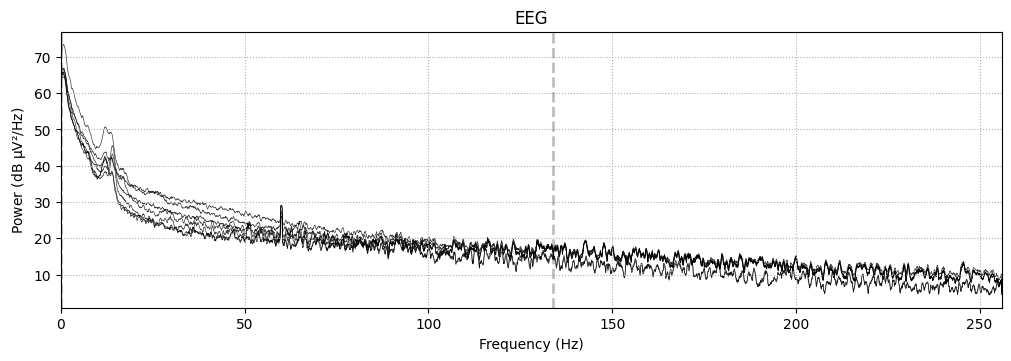

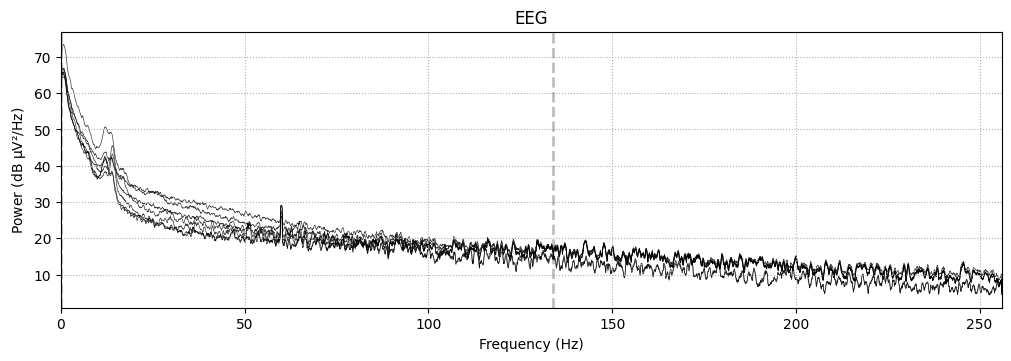

In [24]:
epochs.compute_psd().plot(picks=non_epileptogenic, exclude="bads", amplitude=False)

In [6]:
picks=["n'1", "n'2", "n'3", "n'4", "cc'1", "cc'2", "cc'3", "cc'4"]#, "cc'5", "m'1", "m'2"
#  "m'3", "m'4", "m'5", "sc'2", "sc'3", "sc'4", "sc'5", "sc'6", "lp'1", "lp'2", "lp'3", "lp'4",
#  "lp'5", "y'1", "y'2", "y'3", "y'4", "y'5", "y'6", "oc'1", "oc'2", "oc'3", "oc'4", "op'1", "op'2",
#  "op'3", "op'4", "pi'1", "pi'2", "pi'3", "pa'1", "pa'2", "pa'3", "pa'4"]

In [1]:
file_length_seconds = raw_data.n_times / raw_data.info['sfreq']
file_length_seconds


NameError: name 'raw_data' is not defined

In [ ]:
# Plot the Power Spectral Density (PSD)
# raw_data.plot_psd(fmax=100)  # Adjust fmax to the maximum frequency of interest

# notch_freqs = np.arange(60, raw.info['sfreq'] / 2, 60)
# raw.notch_filter(freqs=notch_freqs)
# raw.filter(l_freq=1, h_freq=100)

# raw.plot_psd()if picks==None:
#         picks=raw_data.ch_names
#         print(picks)


# # Save the epochs to disk
# output_epochs_file = 'Data/full_recording_epochs-epo.fif'
# epochs.save(output_epochs_file, overwrite=True)

# # Check the number of epochs created
# num_epochs = len(epochs)
# print(f"Number of epochs created: {num_epochs}")

In [59]:
frequencies=np.linspace(f_min,f_max,2*int(f_max-f_min))
power = epochs.compute_tfr(
    method="morlet",
    picks=non_epileptogenic,
    freqs=frequencies,
    n_cycles=frequencies/2, #n_ciclos por cada freq
    #time_bandwidth=time_bandwidth,
    return_itc=False,
    #average=True,
    n_jobs=3    
)
#plot.set_title("TFR")
# Plot results. Baseline correct based on first 100 ms.

# power.plot(
#     [0],
#     baseline=(0.0, 0.1),
#     mode="mean",
#     #vlim=(vmin, vmax),
#     #axes=ax,
#     show=False,
#     colorbar=False,
# )

Using data from preloaded Raw for 36 events and 7680 original time points ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   7 out of   7 | elapsed:    7.4s finished


In [54]:
power.data.shape

(36, 7, 140, 7680)

Epochs extent:  0.0 14.998046875 30.0 100.0


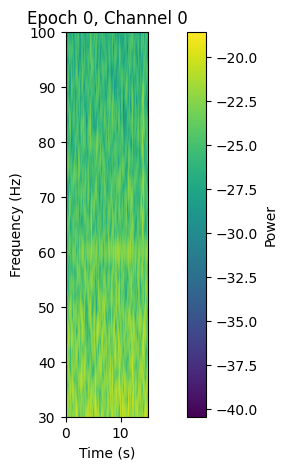

Epochs extent:  0.0 14.998046875 30.0 100.0


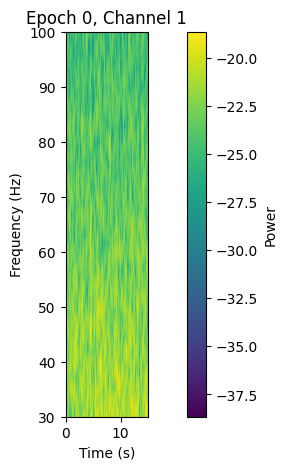

In [60]:
n_epochs,n_channels,n_freqs,n_times=power.data.shape

epoch_idx=8
# ch_idx=6
for epoch_idx in range(1):
    for ch_idx in range(2):
        spectrogram = np.log(power.data[epoch_idx, ch_idx, :, :])

        #epochs.compute_psd().plot(amplitude=False)
        print("Epochs extent: ",epochs.times[0], epochs.times[-1], frequencies[0], frequencies[-1])
        # Plot spectrogram
        plt.figure(figsize=(10, 5))
        plt.imshow(spectrogram, origin='lower',extent=[epochs.times[0], epochs.times[-1], frequencies[0], frequencies[-1]])
        plt.colorbar(label='Power')
        plt.title(f'Epoch {epoch_idx}, Channel {ch_idx }')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()

In [31]:
spectrogram[35:37,5000:5005]

array([[2.09828856e-11, 2.18079167e-11, 2.26508805e-11, 2.35114821e-11,
        2.43889918e-11],
       [1.15658411e-11, 1.23143967e-11, 1.30888616e-11, 1.38879656e-11,
        1.47105279e-11]])